# PyTorch and Mitsuba interoperability

## Overview

This tutorial shows how to mix differentiable computations between Mitsuba and [PyTorch][1]. The ability to combine these frameworks allows us to squeeze an entire rendering pipeline between neural layers whilst still preserving the differentiability (end-to-end) of their combination.

Note that the necessary communication and synchronization between Dr.Jit and PyTorch along with the complexity of traversing two separate computation graph data structures produces an overhead when compared to an implementation which only uses Dr.Jit. We generally recommend sticking with Dr.Jit unless the problem requires neural network building blocks like fully connected layers or convolutions, where PyTorch provides a clear advantage.

In this example, we are going to train a single fully connected layer to pre-distort a texture image to counter the distortion introduced by a refractive object placed in front of the camera when looking at the textured plane. The objective of this optimization will be to minimize the difference between the rendered image and the input texture image.

We assume the reader is familiar with the PyTorch framework or has followed at least the basic [PyTorch tutorials][2].

![](pytorch_tuto_figure.jpg)


<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Use the <code>dr.wrap_ad()</code> function decorator to insert Mitsuba computations in a PyTorch pipeline</li>
</ul>

</div>

[1]: https://pytorch.org
[2]: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## Setup

As always, let's start by importing `mitsuba` and `drjit` and setting an AD-aware variant.

In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

We will then import `torch` as well as `matplotlib` to later display the resulting textures and rendered images.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

<div class="admonition important alert alert-block alert-info">

⚠️ **Note on caching memory allocator**

Similarly to Dr.Jit, PyTorch uses a [caching memory allocator][1] to speed up memory allocations. It is possible for the two frameworks to over allocate memory on the GPU, resulting in allocation failure on the Mitsuba side. When running into such problem, we recommend trying releasing all unoccupied cached memory of PyTorch using `torch.cuda.empty_cache()` which should mitigate this issue.

</div>

[1]: https://pytorch.org/docs/stable/notes/cuda.html#memory-management

## Load texture dataset


In order for the fully connected layer to learn the distortion mapping rather than the distorted textured itself, we are going to train it on multiple input texture images.

The following code loads a few squared images using `mi.Bitmap` and converts them into 32 bits floating point RGB images.

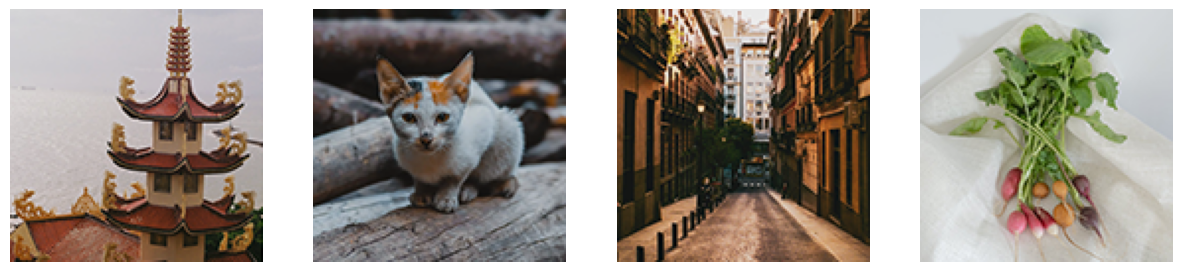

In [3]:
filenames = [
    '../scenes/textures/image_001.png',
    '../scenes/textures/image_002.png',
    '../scenes/textures/image_003.png',
    '../scenes/textures/image_004.png'
]

textures = [
    mi.TensorXf(mi.Bitmap(f).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32))
    for f in filenames
]

#  Helper function to display a list of images (use dict to provide image titles)
def display(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i in range(len(images)):
        img = list(images.values())[i] if isinstance(images, dict) else images[i]
        axs[i].axis('off')
        axs[i].imshow(dr.clip(mi.TensorXf(img), 0.0, 1.0))
        if isinstance(images, dict):
            axs[i].set_title(list(images.keys())[i])

display(textures)

For the sake of simplicity in this tutorial, we will assume that all texture images have the same resolution. Moreover, we will make sure that the pipeline renders images at that resolution to simplify the computation of the objective function.

In [4]:
res = dr.shape(textures[0])[0]

## Scene construction

The scene/setup for this experiment is straighforward. First we instanciate a `perspective` camera that points to the origin where we place a textured plane. Then we place a `sphere` object with a `dielectric` BSDF which will distort the textured image when viewed from the camera. Finally the whole scene is illuminated with a `constant` emitter.

In [5]:
from mitsuba.scalar_rgb import Transform4f as T

scene = mi.load_dict({
    'type': 'scene',
    'integrator': {'type': 'prb'},
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, -2),
                        target=(0, 0, 0),
                        up=(0, -1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width':  res,
            'height': res,
        },
    },
    'textured_plane': {
        'type': 'rectangle',
        'to_world': T.scale(1.2),
        'bsdf': {
            'type': 'twosided',
            'nested': {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'bitmap',
                    'filename': filenames[0]
                },
            }
        }
    },
    'glass_sphere': {
        'type': 'sphere',
        'to_world': T.translate([0, 0, -1]).scale(0.45),
        'bsdf': {
            'type': 'dielectric',
            'int_ior': 1.06,
        },
    },
    'light': {
        'type': 'constant',
    }
})

params = mi.traverse(scene)
key = 'textured_plane.bsdf.brdf_0.reflectance.data'

## Wrap the rendering code

This next block of code is the core of this tutorial. 


We define a simple function that takes a texture image as input, updates the scene and renders it. In order to use this function in our PyTorch pipeline, we need to make sure that PyTorch knows how to propagate gradients through this function during the backpropagation phase. For this, Dr.Jit provides [<code>dr.wrap_ad()</code>][1], a function decorator that automatically inserts a custom operation in the PyTorch `autograd` system when evaluated. Under the hood, this custom operation will call `dr.backward()` internally to propagate the gradients through the rendering algorithm and properly assign the resulting gradient to the input `torch.Tensor` object (here the texture image resulting from the neural network evaluation).

In this tutorial, we are inserting Mitsuba/Dr.Jit computations within a PyTorch pipeline, hence we need to specify `source='torch'` and `target='drjit'` for the `dr.wrap_ad()` decorator to produce a PyTorch custom op. Note that it is also possible to use this decorator to wrap PyTorch computation in a Mitsuba/Dr.Jit pipeline, in which case the `source` and `target` arguments will need to be swapped. The decorator will then automatically insert a Dr.Jit custom op in the Dr.Jit AD graph.

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.wrap_ad
[2]: https://pytorch.org/docs/stable/notes/extending.html

In [6]:
@dr.wrap_ad(source='torch', target='drjit')
def render_texture(texture, spp=256, seed=1):
    params[key] = texture
    params.update()
    return mi.render(scene, params, spp=spp, seed=seed, seed_grad=seed+1)

We can now easily render the scene using the different texture images previously loaded.

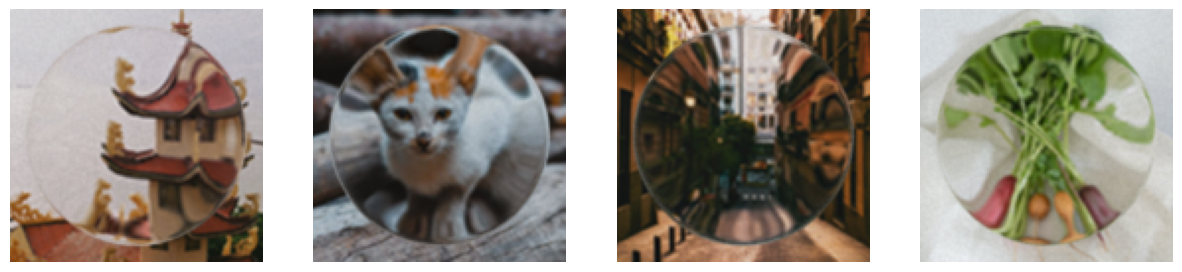

In [7]:
display([render_texture(t) for t in textures])

## Instantiate a fully connected layer

In this synthetic example, we don't really need a neural network as we are only trying to optimize a mapping of pixels from the input texture image to a "pre-distorted" texture image that counteracts the effect of the refractive objects placed in front of the camera.

We are well aware that better techniques could be used to perform such task. Moreover, further processing on the weights of the fully connected layer could be done to improve the convergence of the optimization (e.g. normalization). But for the sake of simplicity, in this tutorial we stick to the basics: a single fully connected layer followed by a sigmoid function to ensure the texture values lie in between `0.0` and `1.0`.

Note that all channels of the image are processed one by one as the mapping should be consistent across channels.

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(res**2, res**2),
            nn.Sigmoid(),
        )

    def forward(self, texture):
        texture = texture.torch()
        # Evaluate the model one channel as a time
        rgb = [self.layers(texture[:, :, i].view(-1)) for i in range(3)]
        # Reconstruct and return the 3D tensor
        return torch.stack([c.view(res, res) for c in rgb], dim=2)

model = Model1()
if 'cuda' in mi.variant():
    model = model.cuda()

As expected, with the weights of the fully connected layer randomly initialized, the pre-distored texture image are completely noisy.

In [ ]:
display([model(t) for t in textures])

## Optimization loop

This optimization loop is similar to the one you will find in any other beginner PyTorch tutorial.

We first initialize an `torch.optim.Adam` optimizer and use the `L1Loss` loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
loss_fn = nn.L1Loss()

# Optimization hyper-parameters
iteration_count = 100
spp = 4

In [ ]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    iteration_count = 2
    spp = 1

At every iteration, we render the Mitsuba scene with the different pre-distorted texture images and propagate the gradients through the entire pipeline using `loss.backward()`. Thanks to `dr.wrap_ad()`, the gradients will seamlessly flow through the rendering algorithm all the way to the neural network weights. We can then call `optimizer.step()` to update the neural network weights. 

In [ ]:
model.train(mode=True)

train_losses = []
for i in range(iteration_count):
    loss_accum = 0
    optimizer.zero_grad()
    for j, texture in enumerate(textures):
        rendered_img = render_texture(model(texture), spp=spp, seed=i*len(textures)+j)
        loss = loss_fn(rendered_img, texture.torch())
        loss.backward()
        loss_accum += loss.item()
    optimizer.step()
    train_losses.append(loss_accum)
    print(f'Training iteration {i+1}/{iteration_count}, loss: {train_losses[-1]}', end='\r')

model.train(mode=False)
plt.plot(train_losses[5:]);

## Results

As you can see in the results below, the fully connected layer is able to properly pre-distort the texture images so that the renderings approximatively match the input images.

These results are far from perfect, which is partially due to the simplicity of the pipeline implemented in this tutorial. For instance, it would make sense to use a smoothing regularization term on the distorted image to reduce the noise observed in the results below. Other neural network architecture might also be more suited for this task.

In [ ]:
for texture in textures:
    distorted = model(texture)
    display({
        'Initial rendered image': render_texture(texture, spp=512),
        'Input texture': texture,
        'Distorted texture': distorted,
        'Rendered image': render_texture(distorted, spp=512),
        'Target image': texture
    })

## See also

- [<code>dr.wrap_ad</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.wrap_ad)